### 1

In [1]:
cd /workspace/HiMol

/workspace/HiMol


In [2]:
from data_utils import MolGraph

smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol_graph = MolGraph(smiles)
mol_graph

/opt/conda/envs/hight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for k in dir(mol_graph):
    if not k.startswith("_"):
        print(k)

edge_attr
edge_attr_nosuper
edge_index
edge_index_nosuper
mol
num_part
size_atom
size_bond
size_edge
size_node
smiles
x
x_nosuper


atoms: 13


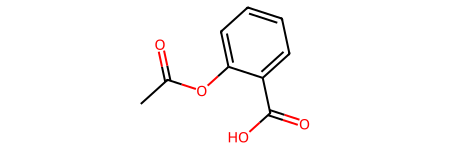

In [4]:
print("atoms:", len(mol_graph.mol.GetAtoms()))
mol_graph.mol

In [5]:
print(f"num_nodes = {mol_graph.x.shape[0]} = sum({', '.join(map(str, mol_graph.num_part))})")

num_nodes = 18 = sum(13, 4, 1)


In [6]:
from data_utils import motif_decomp

cliques = motif_decomp(mol_graph.mol)
cliques

[[0, 1, 2], [4, 5, 6, 7, 8, 9], [10, 11, 12], [3]]

In [ ]:
from rdkit import Chem
from rdkit.Chem import BRICS
from chemutils import get_clique_mol
mol = mol_graph.mol

n_atoms = mol.GetNumAtoms()
if n_atoms == 1:
    print("This molecule has just ONE atoms - No Motifs")

# 모든 bond 각각을 clique로 추가
cliques = []  
for bond in mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()
    cliques.append([a1, a2])

# BRICS decomposition 수행
res = list(BRICS.FindBRICSBonds(mol)) 
breaks = []
if len(res) != 0:
    for bond in res:
        # 추출한 bond가 이미 clique에 들어 있는지 확인하고 제거
        # 1. src -> tgt 있는지 확인하고 제거
        if [bond[0][0], bond[0][1]] in cliques:
            cliques.remove([bond[0][0], bond[0][1]])
        # 아니라면 == 2. tgt -> src 있는지 확인하고 제거
        else:
            cliques.remove([bond[0][1], bond[0][0]])
        
        # 각 원자를 개별 clique로 추가
        cliques.append([bond[0][0]])
        cliques.append([bond[0][1]]) 

        # BRICS로 인해 절단된 지점 저장
        breaks.append(bond)

# clique 병합 -> BRICS는 unique하게 뽑는 게 아니라, 뽑을 수 있는 모든 걸 뽑음
# merge cliques
for c in range(len(cliques) - 1):
    for k in range(c + 1, len(cliques)):
        # 교집합이 있다면 병합
        if len(set(cliques[c]) & set(cliques[k])) > 0: 
            cliques[c] = list(set(cliques[c]) | set(cliques[k]))
            cliques[k] = []
# 1. 빈 리스트로 설정된 (cliques[k] = []) clique들 제거
# 2. 전체 원자수보다 작은 clique만 유지
cliques = [c for c in cliques if len(c) > 0]
cliques = [c for c in cliques if n_atoms > len(c)]

# Ring 처리
num_cli = len(cliques)
ssr_mol = Chem.GetSymmSSSR(mol)
for i in range(num_cli):
    c = cliques[i]
    cmol = get_clique_mol(mol, c)
    ssr = Chem.GetSymmSSSR(cmol)
    if len(ssr)>1:
        for ring in ssr_mol:
            if len(set(list(ring)) & set(c)) == len(list(ring)):
                cliques.append(list(ring))
                cliques[i] = list(set(cliques[i]) - set(list(ring)))
cliques = [c for c in cliques if n_atoms> len(c) > 0]

# 각 clique에 대한 SMARTS 생성
clique_smarts = []
clique_smiles = []
for c in cliques:
    frag = get_clique_mol(mol, c)
    smarts = Chem.MolToSmarts(frag)
    smiles = Chem.MolToSmiles(frag)
    clique_smarts.append(smarts)
    clique_smiles.append(smiles)

cliques, clique_smarts, clique_smiles

([[0, 1, 2], [4, 5, 6, 7, 8, 9], [10, 11, 12], [3]],
 ['[#6]-[#6]=[#8]',
  '[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1',
  '[#8]=[#6]-[#8]',
  '[#8]'],
 ['CC=O', 'c1ccccc1', 'O=CO', 'O'])

In [8]:
import pandas as pd

In [31]:
frags = pd.read_csv("/workspace/GraphGPT/HIGHT/data_preprocess/HiPubChem/rdkit_Data_FragmentDescriptors.csv")
frags.head()

,Code,Description,SMARTS,MOE_SMARTS,Notes
0,fr_C=O,Number of carbonyl O,[CX3]=[OX1],C=O,"Includes carboxylic acids, esters, amides, etc."
1,fr_C=O_noCOO,"Number of carbonyl O, excluding COOH",[C!$(C-[OH])]=O,[C!$(C-[OH])]=O,Excludes COOH but not COO- (assumes no formal ...
2,fr_Al_OH,Number of aliphatic hydroxyl groups,[C!$(C=O)]-[OH],[C!$(C=O)]-[OH],Excludes COOH but not COO- (assumes no formal ...
3,fr_Ar_OH,Number of aromatic hydroxyl groups,c[OH1],c[OH1],-
4,fr_methoxy,Number of methoxy groups -OCH3,[OX2](-[#6])-[CH3],O(-[#6])-CH3,Aliphatic. Includes esters. Includes OMe group...


In [34]:
list(frags["SMARTS"])

['[CX3]=[OX1]',
 '[C!$(C-[OH])]=O',
 '[C!$(C=O)]-[OH]',
 'c[OH1]',
 '[OX2](-[#6])-[CH3]',
 '[CX3]=[NX2]-[OX2]',
 '[#6][CX3](=O)[OX2H0][#6]',
 'C-C(=O)[O;H1,-]',
 'c-C(=O)[O;H1,-]',
 '[#6]C(=O)[O;H,-1]',
 '[CX3](=O)[OX1H0-,OX2H1]',
 '[#6][CX3](=O)[#6]',
 '[OD2]([#6])[#6]',
 '[OX2H]-c1ccccc1',
 '[CX3H1](=O)[#6]',
 '[$([NX4+]),$([NX4]=*)]',
 '[NH2,nH2]',
 '[NH1,nH1]',
 '[NH0,nH0]',
 'n',
 '[nH]',
 'c-[NX3;!$(N=*)]',
 '[Nv3](=C)-[#6]',
 '[NX1]#[CX2]',
 '[NX3]-[NX3]',
 'C=N-[NX3]',
 '[N!$(N-O)]=O',
 '[N!$(N=O)](-O)-C',
 '[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]',
 'N(=O)(O)[#6]',
 '[#6]-N=N-[#6]',
 '[N+]#N',
 '[$(*-[NX2-]-[NX2+]#[NX1]),$(*-[NX2]=[NX2+]=[NX1-])]',
 'C(=O)-N',
 'C(=O)-[NH2]',
 'C(=N)(-N)-[!#7]',
 'C(=N)(N)N',
 '[nH]',
 'N(-C(=O))-C=O',
 'N=C=O',
 'N=C=S',
 'S-C#N',
 '[#9,#17,#35,#53]',
 '[CX4]-[Cl,Br,I,F]',
 '[SX2](-[#6])-C',
 '[SH]',
 'C=[SX1]',
 'S(=,-[OX1;+0,-1])(=,-[OX1;+0,-1])(-[#6])-[#6]',
 'N-S(=,-[OX1;+0,-1])(=,-[OX1;+0,-1])-[#6]',
 '[NH2]-S(=,-[OX1;+0;-1])(=,-[OX1;+0;

In [ ]:
```
from rdkit import Chem
from rdkit.Chem import BRICS
from chemutils import get_clique_mol
mol = mol_graph.mol

n_atoms = mol.GetNumAtoms()
if n_atoms == 1:
    print("This molecule has just ONE atoms - No Motifs")

# 모든 bond 각각을 clique로 추가
cliques = []  
for bond in mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()
    cliques.append([a1, a2])

# BRICS decomposition 수행
res = list(BRICS.FindBRICSBonds(mol)) 
breaks = []
if len(res) != 0:
    for bond in res:
        # 추출한 bond가 이미 clique에 들어 있는지 확인하고 제거
        # 1. src -> tgt 있는지 확인하고 제거
        if [bond[0][0], bond[0][1]] in cliques:
            cliques.remove([bond[0][0], bond[0][1]])
        # 아니라면 == 2. tgt -> src 있는지 확인하고 제거
        else:
            cliques.remove([bond[0][1], bond[0][0]])
        
        # 각 원자를 개별 clique로 추가
        cliques.append([bond[0][0]])
        cliques.append([bond[0][1]]) 

        # BRICS로 인해 절단된 지점 저장
        breaks.append(bond)

# clique 병합 -> BRICS는 unique하게 뽑는 게 아니라, 뽑을 수 있는 모든 걸 뽑음
# merge cliques
for c in range(len(cliques) - 1):
    for k in range(c + 1, len(cliques)):
        # 교집합이 있다면 병합
        if len(set(cliques[c]) & set(cliques[k])) > 0: 
            cliques[c] = list(set(cliques[c]) | set(cliques[k]))
            cliques[k] = []
# 1. 빈 리스트로 설정된 (cliques[k] = []) clique들 제거
# 2. 전체 원자수보다 작은 clique만 유지
cliques = [c for c in cliques if len(c) > 0]
cliques = [c for c in cliques if n_atoms > len(c)]

# Ring 처리
num_cli = len(cliques)
ssr_mol = Chem.GetSymmSSSR(mol)
for i in range(num_cli):
    c = cliques[i]
    cmol = get_clique_mol(mol, c)
    ssr = Chem.GetSymmSSSR(cmol)
    if len(ssr)>1:
        for ring in ssr_mol:
            if len(set(list(ring)) & set(c)) == len(list(ring)):
                cliques.append(list(ring))
                cliques[i] = list(set(cliques[i]) - set(list(ring)))
cliques = [c for c in cliques if n_atoms> len(c) > 0]

# 각 clique에 대한 SMARTS 생성
clique_smarts = []
clique_smiles = []
for c in cliques:
    frag = get_clique_mol(mol, c)
    smarts = Chem.MolToSmarts(frag)
    smiles = Chem.MolToSmiles(frag)
    clique_smarts.append(smarts)
    clique_smiles.append(smiles)
```

위 코드는 주어진 분자를 BRICS 분해를 통해 Clique를 추출하고, 겹치는 부분을 병합하는 과정을 통해서 분해하는 거잖아.
코드에서는 SMARTS나 SMILES를 통해 분해된 결과를 리스트로 반환 (`clique_smarts` 혹은 `clique_smiles`)하게 되는데, 설명을 위해 숫자로 변경해볼게.

예를 들어, 아스피린 ("CC(=O)OC1=CC=CC=C1C(=O)O")의 분해 결과는 `clique_smarts = ['[#6]-[#6]=[#8]', '[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1', '[#8]=[#6]-[#8]', '[#8]'], clique_smiles = ['CC=O', 'c1ccccc1', 'O=CO', 'O']`가 되겠지.
이때, 리스트 안에 들어 올 수 있는 SMARTS, SMILES는 정해져 있어? 만약 그렇다면, 미리 알 수 있는 방법이 있어?

SyntaxError: invalid syntax (1386489571.py, line 1)

In [37]:
from rdkit import Chem
from rdkit.Chem import BRICS

# BRICS 규칙 확인
for i, (env, bnd) in enumerate(BRICS.environs.items()):
    print(f"Rule {i}: {env}")
    print(f"SMARTS: {bnd}")

Rule 0: L1
SMARTS: [C;D3]([#0,#6,#7,#8])(=O)
Rule 1: L3
SMARTS: [O;D2]-;!@[#0,#6,#1]
Rule 2: L4
SMARTS: [C;!D1;!$(C=*)]-;!@[#6]
Rule 3: L5
SMARTS: [N;!D1;!$(N=*);!$(N-[!#6;!#16;!#0;!#1]);!$([N;R]@[C;R]=O)]
Rule 4: L6
SMARTS: [C;D3;!R](=O)-;!@[#0,#6,#7,#8]
Rule 5: L7a
SMARTS: [C;D2,D3]-[#6]
Rule 6: L7b
SMARTS: [C;D2,D3]-[#6]
Rule 7: #L8
SMARTS: [C;!R;!D1]-;!@[#6]
Rule 8: L8
SMARTS: [C;!R;!D1;!$(C!-*)]
Rule 9: L9
SMARTS: [n;+0;$(n(:[c,n,o,s]):[c,n,o,s])]
Rule 10: L10
SMARTS: [N;R;$(N(@C(=O))@[C,N,O,S])]
Rule 11: L11
SMARTS: [S;D2](-;!@[#0,#6])
Rule 12: L12
SMARTS: [S;D4]([#6,#0])(=O)(=O)
Rule 13: L13
SMARTS: [C;$(C(-;@[C,N,O,S])-;@[N,O,S])]
Rule 14: L14
SMARTS: [c;$(c(:[c,n,o,s]):[n,o,s])]
Rule 15: L14b
SMARTS: [c;$(c(:[c,n,o,s]):[n,o,s])]
Rule 16: L15
SMARTS: [C;$(C(-;@C)-;@C)]
Rule 17: L16
SMARTS: [c;$(c(:c):c)]
Rule 18: L16b
SMARTS: [c;$(c(:c):c)]


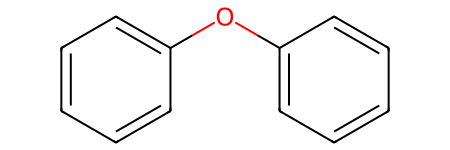

In [42]:
smiles2 = "C1=CC=CC=C1OC1=CC=CC=C1"
mol2 = Chem.MolFromSmiles(smiles2)
mol2

In [43]:
from rdkit import Chem
from rdkit.Chem import BRICS
from chemutils import get_clique_mol

n_atoms = mol2.GetNumAtoms()
if n_atoms == 1:
    print("This molecule has just ONE atoms - No Motifs")

# 모든 bond 각각을 clique로 추가
cliques = []  
for bond in mol2.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()
    cliques.append([a1, a2])

# BRICS decomposition 수행
res = list(BRICS.FindBRICSBonds(mol2)) 
breaks = []
if len(res) != 0:
    for bond in res:
        # 추출한 bond가 이미 clique에 들어 있는지 확인하고 제거
        # 1. src -> tgt 있는지 확인하고 제거
        if [bond[0][0], bond[0][1]] in cliques:
            cliques.remove([bond[0][0], bond[0][1]])
        # 아니라면 == 2. tgt -> src 있는지 확인하고 제거
        else:
            cliques.remove([bond[0][1], bond[0][0]])
        
        # 각 원자를 개별 clique로 추가
        cliques.append([bond[0][0]])
        cliques.append([bond[0][1]]) 

        # BRICS로 인해 절단된 지점 저장
        breaks.append(bond)

# clique 병합 -> BRICS는 unique하게 뽑는 게 아니라, 뽑을 수 있는 모든 걸 뽑음
# merge cliques
for c in range(len(cliques) - 1):
    for k in range(c + 1, len(cliques)):
        # 교집합이 있다면 병합
        if len(set(cliques[c]) & set(cliques[k])) > 0: 
            cliques[c] = list(set(cliques[c]) | set(cliques[k]))
            cliques[k] = []
# 1. 빈 리스트로 설정된 (cliques[k] = []) clique들 제거
# 2. 전체 원자수보다 작은 clique만 유지
cliques = [c for c in cliques if len(c) > 0]
cliques = [c for c in cliques if n_atoms > len(c)]

# Ring 처리
num_cli = len(cliques)
ssr_mol = Chem.GetSymmSSSR(mol2)
for i in range(num_cli):
    c = cliques[i]
    cmol = get_clique_mol(mol2, c)
    ssr = Chem.GetSymmSSSR(cmol)
    if len(ssr)>1:
        for ring in ssr_mol:
            if len(set(list(ring)) & set(c)) == len(list(ring)):
                cliques.append(list(ring))
                cliques[i] = list(set(cliques[i]) - set(list(ring)))
cliques = [c for c in cliques if n_atoms> len(c) > 0]

# 각 clique에 대한 SMARTS 생성
clique_smarts = []
clique_smiles = []
for c in cliques:
    frag = get_clique_mol(mol2, c)
    smarts = Chem.MolToSmarts(frag)
    smiles = Chem.MolToSmiles(frag)
    clique_smarts.append(smarts)
    clique_smiles.append(smiles)

cliques, clique_smarts, clique_smiles

([[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11, 12], [6]],
 ['[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1',
  '[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1',
  '[#8]'],
 ['c1ccccc1', 'c1ccccc1', 'O'])

### 2